In [20]:
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline

In [21]:
# global variable
image_path = "raw_leaf_data/"

In [22]:
def loadImages(path):
    '''
    load image folder into arrays and then return the same array
    '''
    image_files = []
    
    for fold in os.listdir(path):
        image_files = (image_files +
                       sorted([os.path.join(path, fold, file)
                              for file in os.listdir(
                                  os.path.join(path, fold))]))
    
    return image_files

In [23]:
all_images_files = loadImages(image_path)

### Utility functions

#### Display


In [24]:
def display_one(a, title1='Original'):
    '''
    display one image
    '''
    plt.imshow(a)
    plt.title(title1)
    plt.xticks([]), plt.yticks
    plt.show()
    
def display(a, b, title1='Original', title2='Edited'):
    '''
    display two images in subplots
    '''
    plt.subplot(121), plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    
    plt.subplot(122), plt.imshow(b), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    
    plt.show()

#### Preprocessing

In [25]:
def resizing_image(data, h=220, w=220, use_original_size=True, show=True):
    '''
    resizing image size.
    --------------------------
    data: image file path
    h: height
    w: width
    use_original_size: Use original image size
    show: plot the image
    '''
    # loading image
    # getting 3 images to work with
    img  = cv2.imread(data, cv2.IMREAD_UNCHANGED)
    
    print("Original size:", img.shape)
    
    # -----------------------------------
    # setting dim of the resize
    if use_original_size:
        height = img.shape[0]
        width = img.shape[1]
    else:
        height = h
        width = w
    dim = (width, height)
    
    res_img = cv2.resize(img, dim, interpolation=cv2.INTER_LINEAR)
    
    # Checking the size
    print("Resized:", res_img.shape)
    
    # viz the images in the array
    original = res_img
    if show:
        display_one(original)
    
    return res_img

Original size: (3024, 4032, 3)
Resized: (3024, 4032, 3)


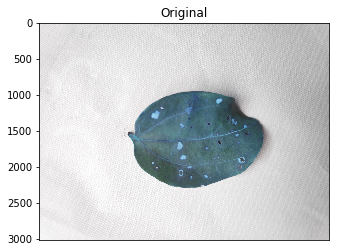

array([[[222, 222, 222],
        [221, 221, 221],
        [228, 228, 228],
        ...,
        [194, 194, 194],
        [197, 197, 197],
        [190, 190, 190]],

       [[224, 224, 224],
        [222, 222, 222],
        [221, 221, 221],
        ...,
        [195, 195, 195],
        [190, 190, 190],
        [187, 187, 187]],

       [[219, 219, 219],
        [220, 220, 220],
        [220, 220, 220],
        ...,
        [193, 193, 193],
        [189, 189, 189],
        [194, 194, 194]],

       ...,

       [[246, 246, 246],
        [246, 246, 246],
        [248, 248, 248],
        ...,
        [185, 185, 185],
        [179, 179, 179],
        [183, 183, 183]],

       [[246, 246, 246],
        [245, 245, 245],
        [248, 248, 248],
        ...,
        [185, 185, 185],
        [191, 191, 191],
        [197, 197, 197]],

       [[246, 246, 246],
        [244, 244, 244],
        [247, 247, 247],
        ...,
        [188, 188, 188],
        [190, 190, 190],
        [192, 192, 192]]

In [26]:
resizing_image(all_images_files[0])

In [27]:
def image_shape_distribution(image_file_paths=all_images_files, verbose=True):
    # loading files
    print('loading files...')
    image_sizes = []
    for i in image_file_paths:
        timg = cv2.imread(i, cv2.IMREAD_UNCHANGED).shape
        image_sizes.append(timg)
        if verbose:
            print('loaded'+ i)
        
    print("printing scatter plot")
    plt.scatter(x=image_sizes[0], y=image_sizes[1])
    plt.show()
    return image_sizes

In [28]:
# (takes a few minutes to load)
#image_size_list = image_shape_distribution(verbose=False)

Original size: (3024, 4032, 3)
Resized: (3024, 4032, 3)


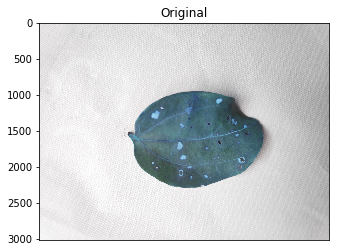

In [29]:
res_img = resizing_image(all_images_files[0])

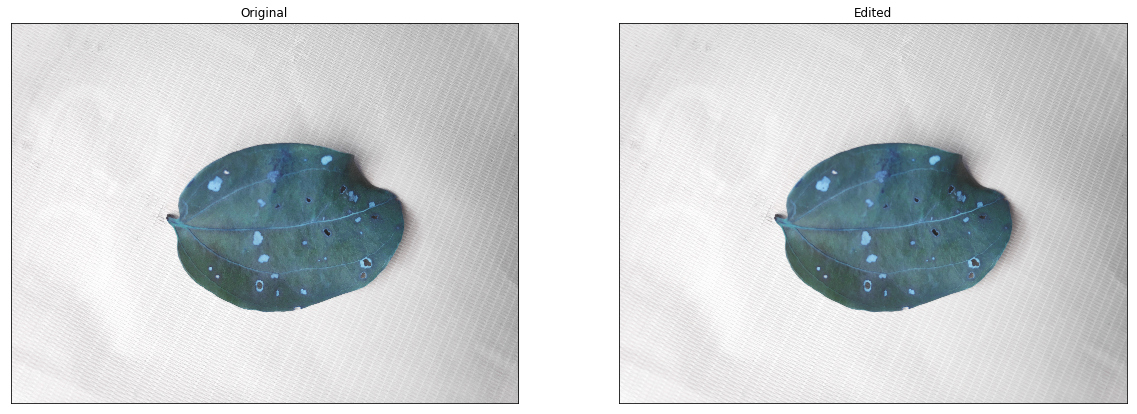

In [30]:
# removing noise using Gaussian smoothing
no_noise=[]

plt.figure(figsize=(20, 10))
blur = cv2.GaussianBlur(res_img, (5,5), 0)
display(res_img, blur)

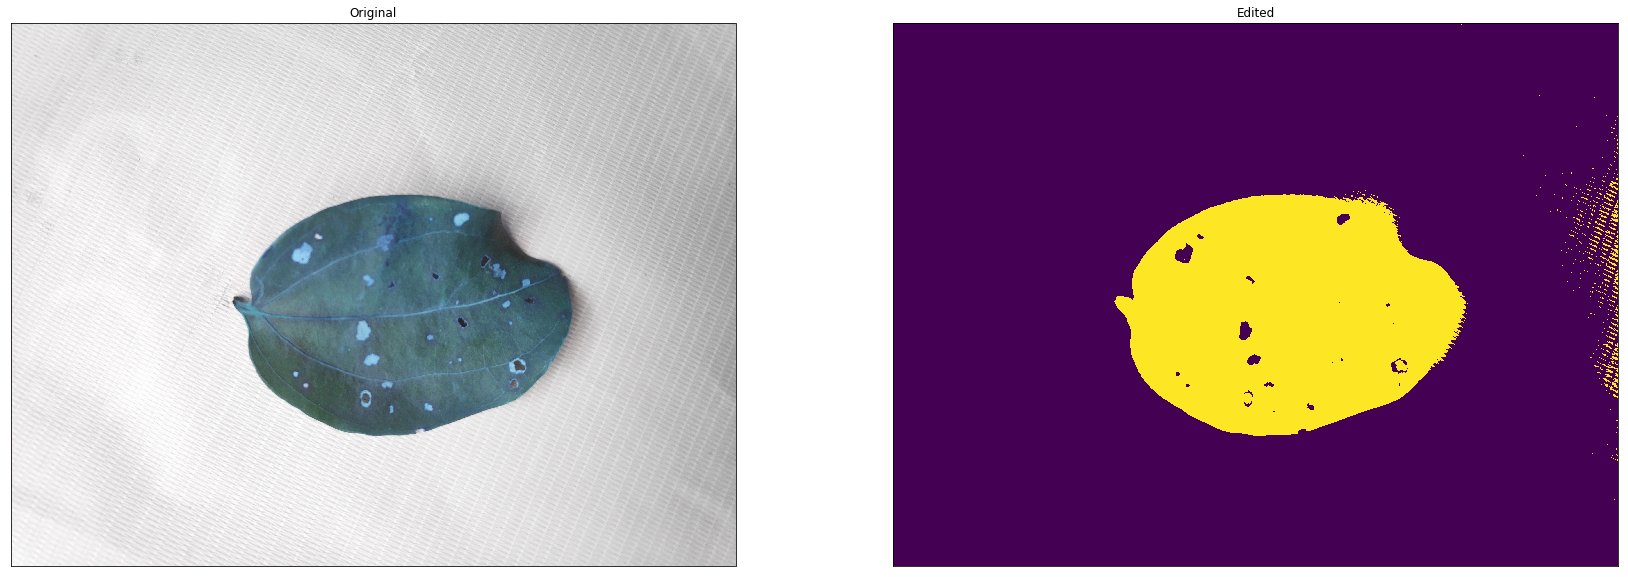

In [31]:
# segmentation
gray = cv2.cvtColor(res_img, cv2.COLOR_RGB2GRAY)
ret, thresh = cv2.threshold(gray, 0, 255,
                            cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.figure(figsize=(29, 10))
# Displaying segmented images
display(res_img, thresh)

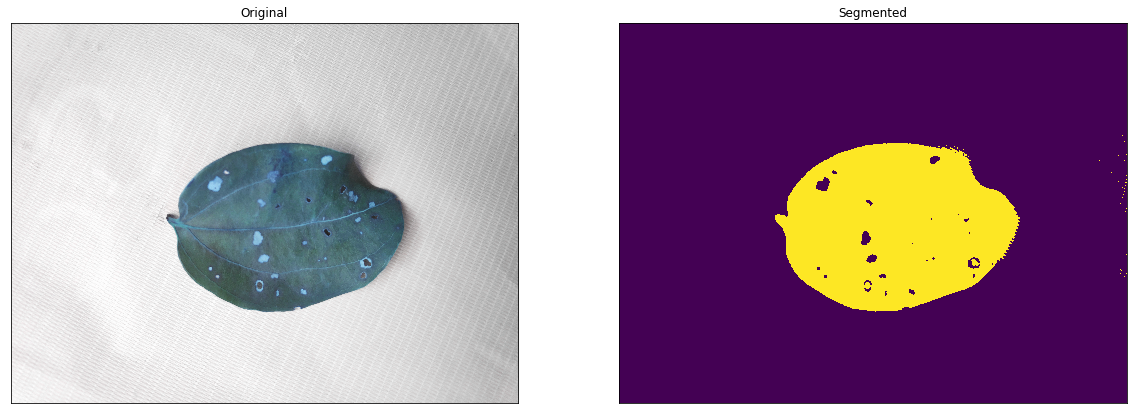

In [32]:
# further noise removal
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# finding sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 3,
                         255, 0)

# displaying segmented back ground
plt.figure(figsize=(20, 10))
display(res_img, sure_fg, title2='Segmented')

In [33]:
# converting into mask type: uint8
mask = cv2.inRange(sure_fg, 255, 255)

# finding contours
contours, hierarchy = cv2.findContours(mask.copy(),
cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2:]

In [34]:
# biggest contour
biggest_contour = max(contours, key=cv2.contourArea)

[1234  959 3186 2298]


TypeError: unhashable type: 'numpy.ndarray'

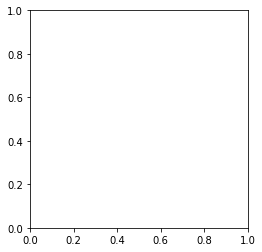

In [35]:
# find center of contour and draw a rectange

(x, y, w, h) = cv2.boundingRect(biggest_contour)
box = [x,y, x+w,y+h]

box = np.asarray(box)
print(box)
# need an extra "min/max" for contours outside the frame
left = box[0]
top = box[1]
right = box[2]
bottom = box[3]
res_img = np.array(res_img[:,::-1])
res = cv2.rectangle(res_img, (left,top), (right,bottom), (255, 100, 100), 2)
plt.imshow('result', res)
